<a href="https://colab.research.google.com/github/jo-cho/advances_in_financial_machine_learning/blob/master/Chapter_05.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Intro

Looking at the sequence of weights, $\omega$, we can appreciate that for $k$ = $0,…,∞$, with $\omega_0$ = 1, the weights can be generated iteratively as:

$$ \omega_k = −\omega_{k−1} \frac{d − k + 1}{k} $$

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

In [0]:
def getWeights(d, size):
  # thres>0 drops insignificant weights
  w = [1.0]
  for k in range(1, size):
    w_ = -w[-1] / k * (d - k + 1)
    w.append(w_)
  w = np.array(w[::-1]).reshape(-1, 1)
  return w

the sequence of weights used to compute each value of the fractionally
differentiated series.

In [0]:
def plotWeights(dRange, nPlots, size):
  w = pd.DataFrame()
  for d in np.linspace(dRange[0], dRange[1], nPlots):
    w_ = getWeights(d, size=size)
    w_ = pd.DataFrame(w_, index=range(w_.shape[0])[::-1], columns=[d])
    w = w.join(w_, how="outer")
  ax = w.plot()
  ax.legend(loc="upper left"); plt.show()
  return

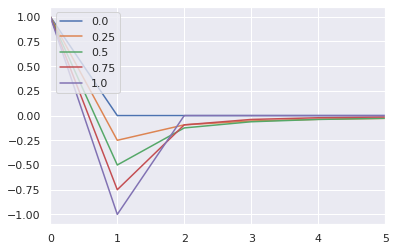

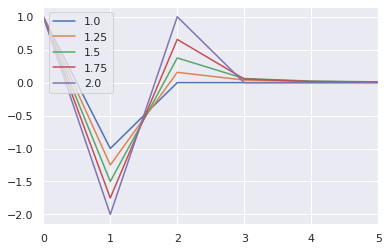

In [4]:
if __name__ == "__main__":
  plotWeights(dRange=[0, 1], nPlots=5, size=6)
  plotWeights(dRange=[1, 2], nPlots=5, size=6)

# Exercises

## 1. Generate a time series from an IID Gaussian random process. This is a memoryless, stationary series:

In [0]:
import numpy.random as rn

In [6]:
df = pd.DataFrame()
ret = rn.randn(1000)
df['ret'] = ret
df.describe()

,ret
count,1000.000000
mean,-0.041682
std,1.021973
min,-3.845281
25%,-0.716426
50%,-0.022915
75%,0.642146
max,3.713729


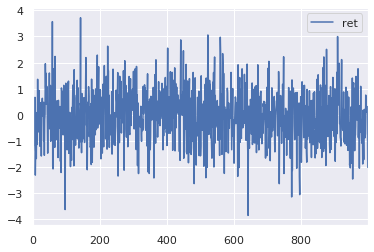

In [7]:
df.plot()

### (a) Compute the ADF statistic on this series. What is the p-value?

In [0]:
from statsmodels.tsa.stattools import adfuller as adf

In [9]:
stat = adf(df.ret)
stat

(-23.712512183587858,
 0.0,
 1,
 998,
 {'1%': -3.4369193380671, '10%': -2.56831430323573, '5%': -2.864440383452517},
 2817.9533083591687)

In [10]:
print('p-value:', stat[1])

p-value: 0.0


### (b) Compute the cumulative sum of the observations. This is a non-stationary series without memory.

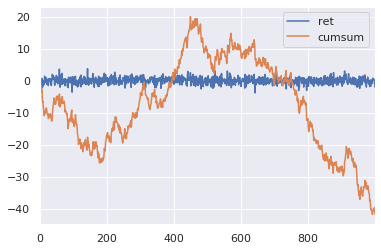

In [11]:
df['cumsum'] = ret.cumsum()
df.plot()

(i) What is the order of integration of this cumulative series?


(ii) Compute the ADF statistic on this series. What is the p-value?

In [12]:
print('p-value: ',adf(df['cumsum'])[1])

p-value:  0.9635662056545087


In [13]:
#'1d' --> I(1)

oned = df['cumsum'].diff().dropna()
print('p-value: ', adf(oned)[1])

p-value:  0.0


### (c) Differentiate the series twice. What is the p-value of this over-differentiated series?

In [0]:
diff2 = df['ret'].diff().diff().dropna()

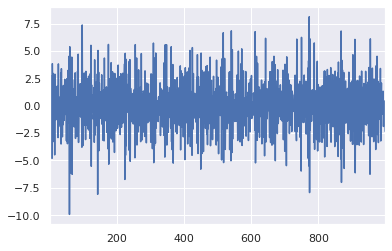

In [15]:
diff2.plot()

In [16]:
print('p-value: ',adf(diff2)[1])

p-value:  1.413109630508856e-27


## 2. Generate a time series that follows a sinusoidal function. This is a stationary series with memory.

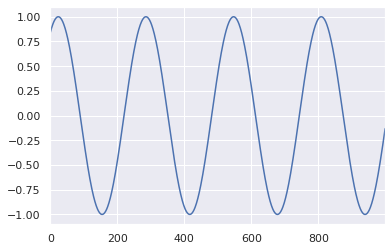

In [17]:
sin = np.sin(np.linspace(1,25,1000))
df['sin'] = sin
df['sin'].plot()

In [18]:
df[['sin']].describe()

,sin
count,1000.000000
mean,-0.018413
std,0.715700
min,-0.999999
25%,-0.729817
50%,-0.062795
75%,0.714026
max,0.999992


### (a) Compute the ADF statistic on this series. What is the p-value?

In [19]:
print('p-value:', adf(df['sin'])[1])

p-value: 0.0


### (b) Shift every observation by the same positive value. Compute the cumulative sum of the observations. This is a non-stationary series with memory.

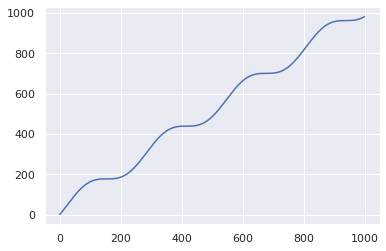

In [20]:
df['sin2'] = (df['sin'] + 1).cumsum()

plt.plot(df['sin2']) 

(i) Compute the ADF statistic on this series. What is the p-value?

(ii) Apply an expanding window fracdiff, with 𝜏 = 1E − 2. For what minimum
d value do you get a p-value below 5%?

(iii) Apply FFD, with 𝜏 = 1E − 5. For what minimum d value do you get a
p-value below 5%?

In [21]:
# (i)
print('p-value:', adf(df['sin2'])[1])

p-value: 1.0


In [22]:
#(ii) & (iii)
# I will import the function from mlfinlab
!pip install -q mlfinlab
import mlfinlab
fracdiff = mlfinlab.fracdiff

     |████████████████████████████████| 122kB 2.6MB/s 


In [0]:
# (ii)
t1 = 1e-2

In [24]:
for d in np.arange(0, 1.0, 0.05):
    s = fracdiff.frac_diff(df[['sin2']], d, thresh=t1).dropna()
    p_val = adf(s['sin2'])[1]    
    if p_val < 0.05:
        print("The minimum d value with a p-value below 5% is:")
        print(d)
        break

The minimum d value with a p-value below 5% is:
0.1


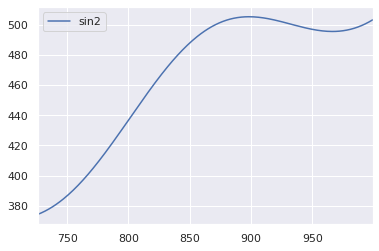

In [25]:
f1 = fracdiff.frac_diff(df[['sin2']], 0.1, thresh=t1).dropna()
f1.plot()

In [26]:
f1

,sin2
726,374.243743
727,374.570715
728,374.913784
729,375.273030
730,375.648524
...,...
995,501.273976
996,501.708453
997,502.159418
998,502.626882


In [27]:
adf(f1['sin2'])[1]

0.00022971652953082789

In [28]:
## (iii)

t2 = 1e-5

for d in np.arange(0, 2.0, 0.05):
    s = fracdiff.frac_diff_ffd(df[['sin2']], d, t2).dropna()
    if len(s['sin2']) >= 2:
      p_val = adf(s['sin2'])[1]    
      if p_val < 0.05:
          print("The minimum d value with a p-value below 5% is:")
          print(d)
          break

The minimum d value with a p-value below 5% is:
1.0


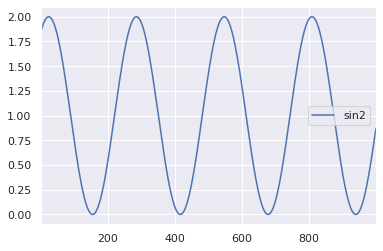

In [29]:
f2 = fracdiff.frac_diff_ffd(df[['sin2']], 1.0, thresh=t2).dropna()
f2.plot()

### 주가를 사용해 FracDiff를 plot해보자

In [0]:
import datetime as dt
import pandas_datareader.data as web

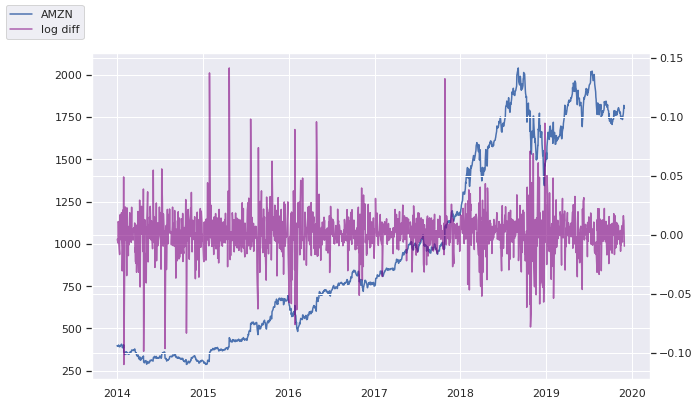

In [31]:
start = dt.datetime(2014,1,1)
end = dt.datetime(2019,12,1)

stock = 'AMZN'

df1 = web.DataReader(stock,'yahoo',start,end)
df1 = df1[['Adj Close']]

ld = df1.pct_change().dropna()

fig, ax1 = plt.subplots( figsize=(10,6))
ax1.plot(df1, label=stock)
ax2 = ax1.twinx()
ax2.plot(ld, label="log diff",c='purple',alpha=0.6)
fig.legend(loc="upper left")
plt.show()

In [0]:
fr1 = fracdiff.frac_diff(df1,0.7, 1).dropna()
fr2 = fracdiff.frac_diff(df1, 0.7, 1e-2).dropna()
fr3 = fracdiff.frac_diff_ffd(df1, 0.7, 1e-5).dropna()

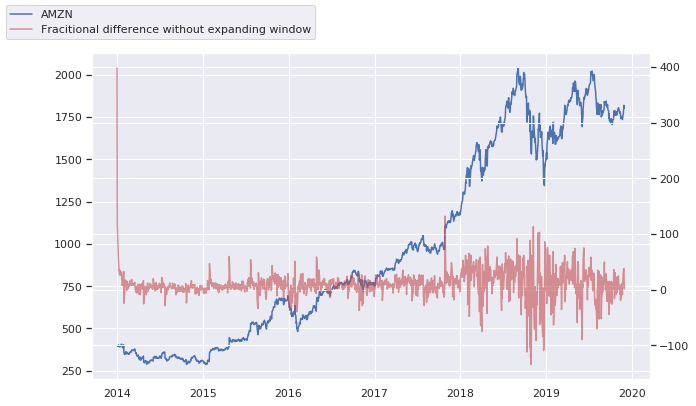

In [33]:
fig, ax1 = plt.subplots( figsize=(10,6))
ax1.plot(df1, label=stock)
ax2 = ax1.twinx()
ax2.plot(fr1, label="Fracitional difference without expanding window",c='r',alpha=0.6)
fig.legend(loc="upper left")
plt.show()

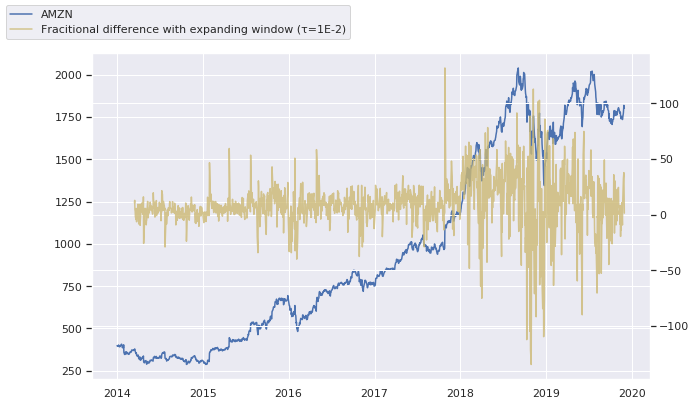

In [34]:
fig, ax1 = plt.subplots( figsize=(10,6))


ax1.plot(df1, label=stock)
ax2 = ax1.twinx()
ax2.plot(fr2, label="Fracitional difference with expanding window (τ=1E-2)",c='y',alpha=0.8)

fig.legend(loc="upper left")


plt.show()

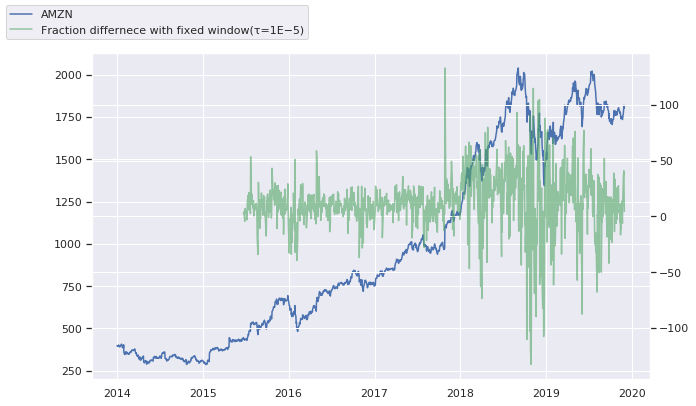

In [35]:
fig, ax1 = plt.subplots( figsize=(10,6))


ax1.plot(df1, label=stock)
ax2 = ax1.twinx()
ax2.plot(fr3, label="Fraction differnece with fixed window(τ=1E−5)",c='g', alpha=0.6)

fig.legend(loc="upper left")


plt.show()

In [36]:
p1= adf(fr1['Adj Close'])[1]
p2= adf(fr2['Adj Close'])[1]
p3= adf(fr3['Adj Close'])[1]
print('p-values of each:',p1,',',p2,',',p3)

p-values of each: 9.400866661148138e-07 , 3.7175904795308835e-06 , 5.802863840382561e-06


## 3. Take the series from exercise 2.b:

### (a) Fit the series to a sine function. What is the R-squared?


In [0]:
from scipy.optimize import curve_fit

def fitsin(tt,yy):
    ''' Fit sin to the input time sequence, and return fitting parameters 
    "amp", "omega", "phase", "offset", "freq", "period" and "fitfunc"
    '''
    tt = np.array(tt)
    yy = np.array(yy)
    ff = np.fft.fftfreq(len(tt), (tt[1]-tt[0]))   # assume uniform spacing
    Fyy = abs(np.fft.fft(yy))
    guess_freq = abs(ff[np.argmax(Fyy[1:])+1])   # excluding the zero frequency "peak", which is related to offset
    guess_amp = np.std(yy) * 2.**0.5
    guess_offset = np.mean(yy)
    guess = np.array([guess_amp, 2.*np.pi*guess_freq, 0., guess_offset])

    def sinfunc(t, A, w, p, c):  return A * np.sin(w*t + p) + c
    
    popt, pcov = curve_fit(sinfunc, tt, yy, p0=guess)
    A, w, p, c = popt
    f = w/(2.*np.pi)
    fitfunc = lambda t: A * np.sin(w*t + p) + c
    
    return {"amp": A, "omega": w, "phase": p, "offset": c, "freq": f, "period": 1./f, 
            "fitfunc": fitfunc, "maxcov": np.max(pcov), "rawres": (guess,popt,pcov)}

https://stackoverflow.com/questions/16716302/how-do-i-fit-a-sine-curve-to-my-data-with-pylab-and-numpy/42322656

In [38]:
res=fitsin(df.index,df['sin2'])
print(res['fitfunc'](df.index))

Float64Index([ 44.77298450294404,  45.61212005674622,  46.45191784195492,
               47.29237679604262,  48.13349585564424,  48.97527395656107,
               49.81771003375911,  50.66080302137232,  51.50455185270414,
               52.34895546022756,
              ...
              1006.7119242701417, 1007.6110618746922, 1008.5096445715656,
               1009.407671223858,  1010.305140695369, 1011.2020518506034,
              1012.0984035547726, 1012.9941946737961, 1013.8894240743016,
              1014.7840906236283],
             dtype='float64', length=1000)


In [0]:
df['fitsin'] = res['fitfunc'](df.index)

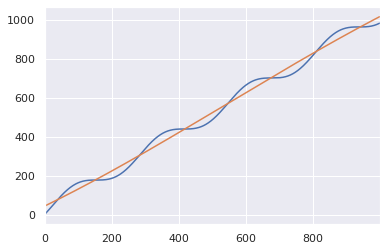

In [40]:
df['sin2'].plot()
df['fitsin'].plot()

In [41]:
from sklearn.metrics import r2_score

r2 = r2_score(df['sin2'], df['fitsin'])
print("R2 score:", r2)

R2 score: 0.9901339262608057


### (b) Apply FFD(d=1). Fit the series to a sine function. What is the R-squared?

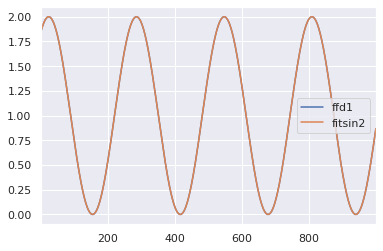

In [42]:
ffd1 = fracdiff.frac_diff_ffd(df[['sin2']], 1).dropna()
fitsin2 = fitsin(ffd1.index, ffd1['sin2'])
fitsin2 = fitsin2['fitfunc'](ffd1.index)

df3=pd.DataFrame()
df3['ffd1'] = ffd1['sin2']
df3['fitsin2'] = fitsin2
df3.plot()

In [43]:
r2_2 = r2_score(df3['ffd1'], df3['fitsin2'])
print("R2 score:", r2_2)

R2 score: 1.0


### (c) What value of d maximizes the R-squared of a sinusoidal fit on FFD(d). Why?

In [44]:
for d in np.arange(0, 1.001, 0.05):
    s = fracdiff.frac_diff_ffd(df[['sin2']], np.round(d,2), thresh=t1).dropna()
    fitsin2 = fitsin(s.index, s['sin2'])
    fitsin2 = fitsin2['fitfunc'](s.index)
    
    df3=pd.DataFrame()
    df3['ffd1'] = s['sin2']
    df3['fitsin2'] = fitsin2
    
    r2 = r2_score(df3['ffd1'], df3['fitsin2'])   
    
    print("when d is ",np.round(d,2),',', '\n',"R2 = ",r2,'\n')

when d is  0.0 , 
 R2 =  0.9901339262608057 

when d is  0.05 , 
 R2 =  0.9900890406127287 

when d is  0.1 , 
 R2 =  0.9900371672783103 

when d is  0.15 , 
 R2 =  0.9899754588728878 

when d is  0.2 , 
 R2 =  0.9899113832835658 

when d is  0.25 , 
 R2 =  0.9898159751439248 

when d is  0.3 , 
 R2 =  0.9897382937913256 

when d is  0.35 , 
 R2 =  0.9896351098392058 

when d is  0.4 , 
 R2 =  0.9895982670046491 

when d is  0.45 , 
 R2 =  0.9894406768044187 

when d is  0.5 , 
 R2 =  0.9893851081755205 

when d is  0.55 , 
 R2 =  0.9893305503653107 

when d is  0.6 , 
 R2 =  0.9890286809848403 

when d is  0.65 , 
 R2 =  0.9889214437526223 

when d is  0.7 , 
 R2 =  0.9888051501917182 

when d is  0.75 , 
 R2 =  0.9880512012493594 

when d is  0.8 , 
 R2 =  0.9876597569754004 

when d is  0.85 , 
 R2 =  0.9870529037622059 

when d is  0.9 , 
 R2 =  0.9858665387298919 

when d is  0.95 , 
 R2 =  0.9818298175151948 

when d is  1.0 , 
 R2 =  1.0 



The r-squared is 1.00 (that is the maximum value). fracDiff_FFD with d=1 makes the series stationary (there is no trend and it is homoscadestic) and since there is no noise the curve fit is complete. 

https://github.com/jo-cho/advances-in-financial-ml-notes/blob/master/Chapter%2005%20-%20Fractionally%20Differentiated%20Features.ipynb

## 4. Take the dollar bar series on E-mini S&P 500 futures. Using the code in Snippet 5.3, for some d ∈ [0, 2], compute fracDiff_FFD(fracDiff_FFD(series,d),-d). What do you get? Why?

In [45]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [46]:
from mlfinlab import data_structures, features, filters, labeling

#달러 바 만들기 (close)
raw_dollar_bars = data_structures.get_dollar_bars('/content/drive/My Drive/Colab Notebooks/csv/clean_IVE_tickbidask2.csv', threshold=1000000)
dollar_bars = raw_dollar_bars.set_index(pd.to_datetime(raw_dollar_bars.date_time))
dollar_bars = dollar_bars.drop(columns='date_time')
dollar_bars = dollar_bars.reset_index().drop_duplicates(subset='date_time', keep='last').set_index('date_time')


Reading data in batches:
Batch number: 0
Returning bars 



In [110]:
rawclose = dollar_bars.close
rawclose

date_time
2009-09-28 09:46:35     51.07
2009-09-28 09:53:49     51.14
2009-09-28 09:55:26     51.14
2009-09-28 10:02:52     51.25
2009-09-28 10:10:21     51.29
                        ...  
2019-06-28 15:58:59    116.56
2019-06-28 15:59:02    116.57
2019-06-28 15:59:45    116.56
2019-06-28 16:00:00    116.57
2019-06-28 17:29:22    116.57
Name: close, Length: 58607, dtype: float64

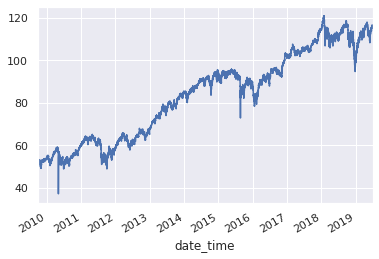

In [111]:
rawclose.plot()

In [51]:
d = 1.5
fd = fracdiff.frac_diff_ffd(fracdiff.frac_diff_ffd(rawclose.to_frame(), d), -d).dropna()
fd

,close
date_time,


In [52]:
d = 0.5
fd = fracdiff.frac_diff_ffd(fracdiff.frac_diff_ffd(rawclose.to_frame(), d), -d).dropna()
fd

,close
date_time,


The result is that the series fd is all NaNs. The reason is when d is negative it takes an almost infinite number of observations for the weights to be lower than the threshold. That in turn leads to all the elements of the "seriesF" in frac_diff_ffd to have a value of NaNs.

참고: https://github.com/jo-cho/research/blob/master/Chapter5/Chapter5_Exercises.ipynb

## 5.

### (a) Form a new series as a cumulative sum of log-prices.

In [112]:
len(rawclose)

58607

In [113]:
close = rawclose[-5000:]
len(close)

5000

In [114]:
cusumlog = np.cumsum(np.log(close))
cusumlog.head()

date_time
2018-12-21 11:51:47     4.604270
2018-12-21 11:54:29     9.209361
2018-12-21 11:56:57    13.813229
2018-12-21 11:58:14    18.415808
2018-12-21 12:01:03    23.017975
Name: close, dtype: float64

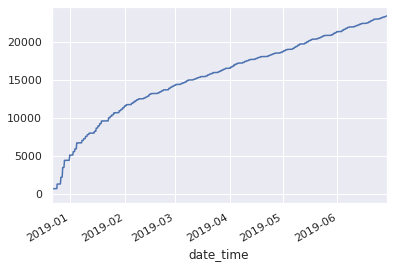

In [115]:
cusumlog.plot()

### (b) Apply FFD, with 𝜏 = 1E − 5. Determine for what minimum d ∈ [0, 2] the new series is stationary.

In [116]:
for d in np.arange(0, 2.5, 0.05):
    s = fracdiff.frac_diff_ffd(cusumlog.to_frame(),np.round(d,2)).dropna()
    if len(s['close']) >= 2 :
      p = adf(s['close'])[1]
      if p<0.05:
        print("minimum d is", np.round(d,4), 'with p-value',p)
        break

minimum d is 2.0 with p-value 0.0


### (c) Compute the correlation of the fracdiff series to the original (untransformed) series.

In [0]:
fd = fracdiff.frac_diff_ffd(cusumlog.to_frame(), 2).dropna()

In [0]:
fdseries = fd.close

In [122]:
dffd = pd.concat({'original':close,'cusum':cusumlog,'fracdiff':fdseries},axis=1)
dffd.dropna()

,original,cusum,fracdiff
date_time,,,
2018-12-21 11:56:57,99.8699,13.813229,-0.001223
2018-12-21 11:58:14,99.7412,18.415808,-0.001290
2018-12-21 12:01:03,99.7001,23.017975,-0.000412
2018-12-21 12:02:10,99.8000,27.621143,0.001002
2018-12-21 12:02:18,99.7900,32.224211,-0.000100
...,...,...,...
2019-06-28 15:58:59,116.5600,23369.493569,-0.000858
2019-06-28 15:59:02,116.5700,23374.252061,0.000086
2019-06-28 15:59:45,116.5600,23379.010467,-0.000086


In [123]:
dffd.dropna(inplace=True)
dffd.corr()

,original,cusum,fracdiff
original,1.000000,0.933522,0.013149
cusum,0.933522,1.000000,0.001864
fracdiff,0.013149,0.001864,1.000000


### (d) Apply an Engel-Granger cointegration test on the original and fracdiff series. Are they cointegrated? Why?

In [124]:
from statsmodels.tsa.stattools import coint

coint = coint(dffd['original'], dffd['fracdiff'], autolag='AIC')
coint

(-0.7550145444612716,
 0.9403643885314109,
 array([-3.89863304, -3.33735303, -3.04529886]))

In [125]:
print('p-value: {}'.format(coint[1]),'\n','they are not cointegrated')

p-value: 0.9403643885314109 
 they are not cointegrated


why??

### (e) Apply a Jarque-Bera normality test on the fracdiff series

In [0]:
from scipy.stats import jarque_bera

In [127]:
jb_test = jarque_bera(fdseries)
print('P-value: {}'.format(jb_test[1]))

P-value: 0.0


## 6. 

### (a) Apply a CUSUM filter (Chapter 2), where h is twice the standard deviation of the series.

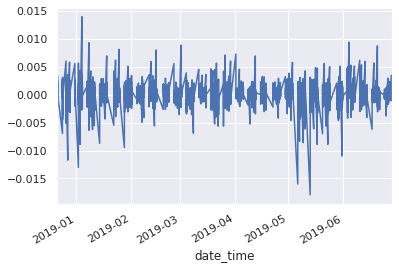

In [128]:
fdseries.plot()

In [0]:
fdseries2 = fdseries.copy()

In [130]:
fdseries2.std()

0.001421347900053483

In [131]:
h = 2*fdseries2.std()
t_events = filters.cusum_filter(fdseries2,h)
t_events

/usr/local/lib/python3.6/dist-packages/pandas/core/algorithms.py:1977: RuntimeWarning: invalid value encountered in subtract
  out_arr[res_indexer] = arr[res_indexer] - arr[lag_indexer]


DatetimeIndex(['2018-12-21 12:23:55', '2018-12-21 12:33:31',
               '2018-12-21 12:35:19', '2018-12-21 12:39:29',
               '2018-12-21 12:46:14', '2018-12-21 12:46:56',
               '2018-12-21 12:48:32', '2018-12-21 13:00:50',
               '2018-12-21 13:26:52', '2018-12-21 13:41:55',
               ...
               '2019-06-27 10:09:28', '2019-06-27 10:51:55',
               '2019-06-27 12:35:23', '2019-06-27 13:07:45',
               '2019-06-27 14:08:04', '2019-06-28 12:20:41',
               '2019-06-28 12:39:45', '2019-06-28 15:53:24',
               '2019-06-28 15:58:18', '2019-06-28 17:29:22'],
              dtype='datetime64[ns]', length=1382, freq=None)


### (b) Use the filtered timestamps to sample a features’ matrix. Use as one of the features the fracdiff value.


In [132]:
close_feat = close.loc[t_events]
fd_feat = fdseries.loc[t_events]
ft = (pd.DataFrame().assign(d_feat=close_feat, fd_feat=fd_feat).drop_duplicates().dropna())
print(ft)

                       d_feat   fd_feat
2018-12-21 12:23:55   99.4000  0.000241
2018-12-21 12:33:31   99.2550  0.000958
2018-12-21 12:35:19   99.2902  0.000355
2018-12-21 12:39:29   99.4200  0.001292
2018-12-21 12:46:14   99.4210  0.000402
...                       ...       ...
2019-06-28 12:20:41  116.4800  0.000772
2019-06-28 12:39:45  116.5567  0.000658
2019-06-28 15:53:24  116.4400  0.000601
2019-06-28 15:58:18  116.6600  0.001888
2019-06-28 17:29:22  116.5700  0.000000

[1381 rows x 2 columns]


In [133]:
mlfinlab.sampling.concurrent.num_concurrent_events(fdseries.index, events.t1, molecule=events.index )

date_time
2019-02-27 14:45:01     1
2019-02-27 14:54:53     1
2019-02-27 15:10:13     0
2019-02-27 15:13:14     1
2019-02-27 15:26:57     1
                       ..
2019-06-28 15:58:59    14
2019-06-28 15:59:02    14
2019-06-28 15:59:45    14
2019-06-28 16:00:00    14
2019-06-28 17:29:22    15
Length: 1966, dtype: int64

### (c) Form labels using the triple-barrier method, with symmetric horizontal barriers of twice the daily standard deviation, and a vertical barrier of 5 days.

In [0]:
from mlfinlab import util

In [0]:
target = util.get_daily_vol(fdseries)

In [0]:
vertical_barrier_times = labeling.add_vertical_barrier(t_events, fdseries, num_days=5)
pt_sl = [2,2]

In [137]:
# Get Events
events = labeling.get_events(fdseries, t_events, pt_sl, target, min_ret=0.001, num_threads=1, vertical_barrier_times=vertical_barrier_times )

/usr/local/lib/python3.6/dist-packages/mlfinlab/labeling/labeling.py:124: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  target = target.loc[t_events]


In [138]:
events.head()

,t1,trgt,pt,sl
2018-12-24 09:41:26,2018-12-31 09:30:00,174.920163,2,2
2018-12-24 09:59:28,2018-12-31 09:30:00,106.421025,2,2
2018-12-24 10:00:13,2018-12-31 09:30:00,104.302552,2,2
2018-12-24 10:01:39,2018-12-31 09:30:00,101.489368,2,2
2018-12-24 10:11:27,2018-12-31 09:30:00,93.148346,2,2


In [139]:
bins = labeling.get_bins(events, fdseries)
bins['bin'].value_counts()

/usr/local/lib/python3.6/dist-packages/mlfinlab/labeling/labeling.py:232: RuntimeWarning: divide by zero encountered in log
  out_df['ret'] = np.log(prices.loc[events_['t1'].values].values) - np.log(prices.loc[events_.index])
/usr/local/lib/python3.6/dist-packages/mlfinlab/labeling/labeling.py:232: RuntimeWarning: invalid value encountered in log
  out_df['ret'] = np.log(prices.loc[events_['t1'].values].values) - np.log(prices.loc[events_.index])
/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:856: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 0    1307
 1      30
-1      11
Name: bin, dtype: int64

### (d) Fit a bagging classifier of decision trees where:

(i) The observed features are bootstrapped using the sequential method from Chapter 4. 

(ii) On each bootstrapped sample, sample weights are determined using the techniques from Chapter 4.

In [0]:
from mlfinlab.sampling.bootstrapping import get_ind_mat_average_uniqueness, get_ind_matrix, seq_bootstrap
from mlfinlab.sampling.concurrent import get_av_uniqueness_from_triple_barrier

In [141]:
av_uniq = get_av_uniqueness_from_triple_barrier(events, fdseries, 3)
av_uniq

2019-12-16 09:47:08.805292 100.0% num_concurrent_events done after 0.02 minutes. Remaining 0.0 minutes.
2019-12-16 09:47:09.745162 100.0% _get_average_uniqueness done after 0.01 minutes. Remaining 0.0 minutes.


,tW
2018-12-24 09:41:26,0.035665
2018-12-24 09:59:28,0.022339
2018-12-24 10:00:13,0.021738
2018-12-24 10:01:39,0.021346
2018-12-24 10:11:27,0.019019
...,...
2019-06-28 12:20:41,NaN
2019-06-28 12:39:45,NaN
2019-06-28 15:53:24,NaN
2019-06-28 15:58:18,NaN


In [142]:
# get avg uniqueness for bootstrapping
max_samples = av_uniq.mean()[0]
max_samples

0.036501273474702944

let's fit

In [0]:
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp

from sklearn import datasets
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, BaggingClassifier
from itertools import cycle

 model data

In [144]:
data = ft.join(av_uniq,how='left').join(bins.bin,how='left').dropna()
data

,d_feat,fd_feat,tW,bin
2018-12-24 09:41:26,97.1233,0.000137,0.035665,0.0
2018-12-24 09:59:28,96.4218,0.001264,0.022339,0.0
2018-12-24 10:00:13,96.4800,0.000603,0.021738,0.0
2018-12-24 10:01:39,96.4980,0.000187,0.021346,0.0
2018-12-24 10:11:27,96.2700,0.002392,0.019019,0.0
...,...,...,...,...
2019-06-21 15:23:05,116.5000,0.000429,0.070297,0.0
2019-06-21 15:41:24,116.5067,0.000058,0.038846,0.0
2019-06-21 15:44:05,116.5200,0.000114,0.073228,0.0
2019-06-27 10:51:55,115.7098,0.000018,0.111111,0.0


In [0]:
X = data.iloc[:,:-1].values # features
y = data.iloc[:,-1].values.reshape(-1,1) # bin

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,
                                                    shuffle=False)

In [0]:
dtclf = DecisionTreeClassifier(criterion='entropy',max_features='auto',
                                  class_weight='balanced')

bclf = BaggingClassifier(base_estimator=dtclf, n_estimators=1000,
                       max_samples= max_samples, max_features=1.)

clf = OneVsRestClassifier(bclf)

fit = clf.fit(X_train,y_train)

#train

In [148]:
y_pred = fit.predict(X)
print(metrics.classification_report(y, y_pred))

              precision    recall  f1-score   support

        -1.0       0.00      0.00      0.00        11
         0.0       0.97      1.00      0.98      1306
         1.0       0.00      0.00      0.00        30

    accuracy                           0.97      1347
   macro avg       0.32      0.33      0.33      1347
weighted avg       0.94      0.97      0.95      1347



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
